In [2]:
import torch
import torch.nn as nn
from torch_geometric.data import Batch, Data

import numpy as np
import matplotlib.pyplot as plt

from layers.ect import EctLayer
from layers.config import EctConfig


from datasets.mnist import MnistDataModule 
from datasets.config import MnistDataModuleConfig

from pytranskit.optrans.continuous.cdt import CDT
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"


dataset = MnistDataModule(MnistDataModuleConfig())



c:\Users\Ernst\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
NUM_PTS = 100
DEVICE = 'cuda:0'
NUM_THETAS = 64

V = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
        torch.cos(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
    ]
)


CONFIG = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,normalized=True,device=DEVICE)


# Interpolation

In [4]:
def cdt_interpolation(ect_start, ect_end,steps=100):
    ect_start = ect_start.cpu().squeeze().detach().numpy()
    ect_end = ect_end.cpu().squeeze().detach().numpy()
    N=NUM_THETAS
    x0 = np.linspace(0, 1, N)
    I0= np.ones(x0.size)
    x=np.linspace(0, 2, N)
    num_thetas = NUM_THETAS
    ect = np.zeros((num_thetas,num_thetas))
    I1 = abs(ect_start) + 1e-7
    I2 = abs(ect_end) + 1e-7

    I1 = I1/I1.sum(axis=0)
    I2 = I2/I2.sum(axis=0)
    
    taus = np.linspace(0,1,steps)
    cdt1 = CDT()
    inter = []

    for tau in taus: 
        for idx in range(num_thetas):
            # Compute the forward transform
            I1_hat, _, _ = cdt1.forward(x0, I0, x, I1[:,idx], rm_edge=False)
            I2_hat, _, _ = cdt1.forward(x0, I0, x, I2[:,idx], rm_edge=False)


            I_hat = ( tau ) * I1_hat + ( 1 - tau ) * I2_hat  
            I_recon = cdt1.inverse(I_hat, I0, x)

            ect[:,idx] = I_recon
            
        inter.append(ect)
        ect = np.zeros((num_thetas,num_thetas))
    return torch.tensor(np.stack(inter).cumsum(axis=1),dtype=torch.float,device=DEVICE)


def linear_interpolation(ect_start, ect_end,steps=100):
    taus = torch.linspace(0,1,steps=100,device=DEVICE).unsqueeze(1).unsqueeze(1)
    return taus * ect_start.unsqueeze(0).repeat(100,1,1) + (1-taus) *  ect_end.unsqueeze(0).repeat(100,1,1)
    




In [5]:
for test_batch in dataset.train_dataloader():
    break

derlayer = EctLayer(config = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,device=DEVICE,ect_type="points_derivative",normalized=True),v=V)
ectlayer = EctLayer(config = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,device=DEVICE,ect_type="points",normalized=True),v=V)

ect_batch = derlayer(test_batch.to(DEVICE))


In [6]:
test_batch = Batch.from_data_list(
    [
        Data(x=torch.tensor([[0.4,0.7],[0.4,0.7]])),
        Data(x=torch.tensor([[-0.4,-0.7]]))
    ]
).to(DEVICE)

res = ectlayer(test_batch)
res_cdt = derlayer(test_batch)

interp_linear = linear_interpolation(res[0],res[1].squeeze()).cpu()
interp_cdt = cdt_interpolation(res_cdt[0],res_cdt[1].squeeze()).cpu()


# for idx, img in enumerate(interp): 
#     plt.imsave(f"./ect/{idx}.jpg",img.cpu().squeeze(),dpi=1000)

# import imageio
# images = []
# for idx in range(100):
#     images.append(imageio.imread(f"./ect/{idx}.jpg"))
# imageio.mimsave('movie_mnist_cdt.gif', images)

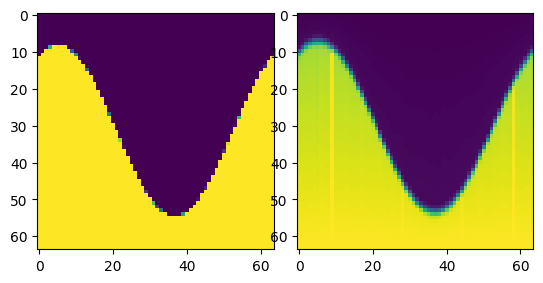

In [7]:
# First set up the figure, the axis, and the plot element we want to animate

fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(wspace=.1,hspace=.1)
# axes.set_aspect(1)

# initialization function: plot the background of each frame
def init():
    axes[0].imshow(interp_linear[0])
    axes[1].imshow(interp_cdt[0])
    return None,


# animation function.  This is called sequentially
def animate(i):
    axes[0].imshow(interp_linear[i])
    axes[1].imshow(interp_cdt[i])
    

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, 
                               animate, 
                               init_func=init,
                               frames=100, 
                               interval=80
                               )

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


anim.save('ect_interp.mp4', fps=30, extra_args=['-vcodec', 'libx264'])




In [ ]:

# for idx in range(100):
#     # cent = internal_batch.centers[idx]
    
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

#     pts = model.encoder(interp[idx].view(1,NUM_THETAS,NUM_THETAS)).view(-1,2).cpu().detach().numpy()

#     ax = axes[0]
#     ax.axis("off")
#     ax.scatter(pts[:,0],pts[:,1])

#     ax = axes[1]
#     ax.axis("off")
#     ax.imshow(interp[idx].cpu().squeeze().detach().numpy())

#     fig.savefig(f"./imgs/{idx}.jpg")

C:\Users\Ernst\AppData\Local\Temp\ipykernel_11100\2585850001.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"./ect/{idx}.jpg"))
